### Shrinkage FRED-MD

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,Lasso,ElasticNetCV,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
FREDMD = pd.read_excel("FREDMDdata.xlsx", sheet_name=0)
y = FREDMD['INDPRO'].values
X = FREDMD.drop(columns=['INDPRO'])

In [3]:
### OLS
ols = LinearRegression(fit_intercept=True).fit(X, y)
print(ols.coef_)

[ 2.56959488e-01 -1.96470685e-01 -5.90799663e-03 -1.14528984e-02
  2.37271330e-03 -2.80181585e-03 -8.19640815e-04  5.56286574e-01
 -5.28846344e-02 -7.76473707e-02  2.92456375e-02  6.67301751e-02
  9.70350801e-03  4.34852874e-01 -2.79847805e-02 -5.66751680e-03
  1.92028426e-02  1.12486670e-03  9.67217109e-04  3.69039088e-04
  2.10686352e-05 -2.23480958e-02  3.79293764e-02 -1.80967242e-02
 -1.34369787e-03  1.87903481e-04  1.86218240e-03  7.35645975e-04
  1.48764816e-04 -3.01829746e-04 -5.19075172e-04  3.40488637e-04
 -3.37412698e-01  2.31029590e-01  1.93593853e-04 -2.56636783e-02
 -3.84953701e-01  1.80021858e-01  1.06458848e-01  2.43741098e-01
 -2.18499933e-02 -2.66544508e-03 -1.11102164e-02 -2.86459890e-03
  6.03248880e-03 -4.38904663e-05 -3.24247559e-04  6.77694268e-05
  1.48040029e-03  2.11552558e-06 -3.58941395e-04 -3.43544899e-04
 -2.55778873e-04 -1.17224695e-03  3.48168843e-06  4.94364156e-04
  2.68816908e-04  1.16337740e-04  5.27294602e-04  5.10481126e-03
  4.03242937e-03  1.10192

In [4]:
# 표준화하기
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Ridge CV
from sklearn.model_selection import cross_validate
from scipy.stats import sem

ridge_cv = RidgeCV(alphas=np.logspace(-5, 5, 100),
                    store_cv_values=True).fit(X_scaled, y)

mse_path = ridge_cv.cv_values_

mean_mse = mse_path.mean(axis=0)
se_mse = sem(mse_path, axis=1)

# MSE가 가장 작은 alpha 값 찾기
alpha_min = ridge_cv.alpha_
min_mse = mean_mse[np.argmin(mean_mse)]

# 1SE rule로 alpha 찾기
alpha_1se = max(ridge_cv.alphas[mean_mse<=min_mse+se_mse[np.argmin(mean_mse)]])

# R과 스케일이 달라서 파라미터 값의 차이가 더 큰 것처럼 나타남.
print(f"[alpha.min] {alpha_min:.6f}")
print(f"[alpha.1se] {alpha_1se:.6f}")

[alpha.min] 0.705480
[alpha.1se] 18.307383


In [6]:
### MSE가 가장 작은 alpha와 1SE 범위 내에서 가장 큰 alpha를 이용한 Coef
ridge_mse = Ridge(alpha=alpha_min).fit(X_scaled, y)
print("\n[Min MSE Coef]", ridge_mse.coef_)

ridge_1se = Ridge(alpha=alpha_1se).fit(X_scaled, y)
print("\n[1 SE Coef]", ridge_1se.coef_)


[Min MSE Coef] [-5.88761897e-06 -3.34595077e-04 -1.04476892e-05 -4.98935430e-05
  2.59531054e-05 -4.70552865e-05 -1.28210235e-05  3.71520817e-03
 -1.67972206e-04 -2.74624452e-04  3.37015141e-04  2.41849262e-04
  1.04096586e-04  4.07826062e-03 -3.88095389e-04 -4.03471876e-05
  3.99741757e-04  6.01387428e-05  1.98484821e-05  2.20476891e-04
  3.61069761e-05  5.53151861e-06  3.76785194e-05  2.04076202e-05
 -2.20525033e-04  9.53417232e-05  1.19549456e-04  5.57928498e-05
  1.08271015e-05 -8.87352348e-06 -2.06304148e-05  2.05289594e-05
 -3.07413508e-04  5.41749736e-04  7.16024129e-05 -1.55916569e-04
 -1.46656734e-04 -3.12461984e-05 -4.54783116e-05  1.56272414e-04
 -3.86462565e-05  1.57120459e-06 -4.25343403e-05  7.78418888e-06
  2.11972146e-05  1.01161462e-05 -4.29787723e-05  1.66975854e-05
  1.21286153e-04  5.37407149e-05 -5.85288124e-05 -4.83060373e-06
 -9.16634579e-06  2.02914490e-06 -5.30431913e-05  8.22763916e-05
 -4.36961624e-05 -5.39932924e-05  3.36164477e-05  3.62995785e-05
  2.34728

In [7]:
# Lasso CV
lasso_cv = LassoCV(alphas=np.logspace(-5, 5, 100),
                    cv=KFold(n_splits=10, shuffle=True, random_state=42),
                     max_iter=10000).fit(X_scaled, y)

mse_path = lasso_cv.mse_path_

mean_mse = mse_path.mean(axis=1)
se_mse = sem(mse_path, axis=1)

# MSE가 가장 작은 alpha 값 찾기
alpha_min = lasso_cv.alpha_
min_mse = mean_mse[np.argmin(mean_mse)]

# 1SE rule로 alpha 찾기
alpha_1se = max(lasso_cv.alphas_[mean_mse<=min_mse+se_mse[np.argmin(mean_mse)]])

# R과 스케일이 달라서 파라미터 값의 차이가 더 큰 것처럼 나타남.
print(f"[alpha.min] {alpha_min:.6f}")
print(f"[alpha.1se] {alpha_1se:.6f}")

[alpha.min] 0.000025
[alpha.1se] 0.000163


In [8]:
### Coef
lasso_mse = Lasso(alpha=alpha_min).fit(X_scaled, y)
print("\n[Min MSE Coef]", lasso_mse.coef_)

lasso_1se = Lasso(alpha=alpha_1se).fit(X_scaled, y)
print("\n[1 SE Coef]", lasso_1se.coef_)


[Min MSE Coef] [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  4.04039161e-03
  0.00000000e+00  0.00000000e+00  3.72903681e-05  0.00000000e+00
  0.00000000e+00  3.97518124e-03 -0.00000000e+00  6.58899711e-05
  7.35373167e-05  0.00000000e+00  1.46654109e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.76747857e-05
 -7.06934585e-05  1.98896613e-05  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -7.08553463e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.07882208e-04 -0.00000000e+00
  0.00000000e+00  4.66637383e-05  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.32203691e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.99015490e-05
  0.00000000e+00  0.00000000e+00  2.09324840e-05  4.52706512e-06
  0.00000

In [9]:
# CV를 활용한 변수 선택 (MSE 기준)
selected_cv_mse = np.where(lasso_mse.coef_ != 0)[0]
selected_vars_msecv = X.columns[selected_cv_mse]
selected_coefs_msecv = lasso_mse.coef_[selected_cv_mse]

selected_vars_msecv.tolist(), selected_coefs_msecv

(['IPFPNSS',
  'IPDCONGD',
  'IPMAT',
  'IPNMAT',
  'IPMANSICS',
  'IPFUELS',
  'CE16OV',
  'UNRATE',
  'UEMPMEAN',
  'UEMP15T26',
  'CES1021000001',
  'DMANEMP',
  'AWOTMAN',
  'PERMITMW',
  'AMDMNOx',
  'AMDMUOx',
  'S.P.500',
  'FEDFUNDS',
  'CP3Mx',
  'EXSZUSx',
  'WPSFD49207',
  'CES2000000008'],
 array([ 4.04039161e-03,  3.72903681e-05,  3.97518124e-03,  6.58899711e-05,
         7.35373167e-05,  1.46654109e-05,  1.76747857e-05, -7.06934585e-05,
         1.98896613e-05, -7.08553463e-06,  1.07882208e-04,  4.66637383e-05,
        -1.32203691e-05,  1.99015490e-05,  2.09324840e-05,  4.52706512e-06,
        -1.62632181e-05,  9.86637700e-06,  2.02534795e-05,  1.17049524e-05,
        -4.99590559e-05, -4.69935792e-05]))

In [9]:
### Information Criteria
from sklearn.linear_model import LassoLarsIC

model_bic = LassoLarsIC(criterion='bic', fit_intercept=True)
model_bic.fit(X_scaled, y)

LassoLarsIC(criterion='bic')

In [10]:
print("Selected alpha:", model_bic.alpha_)

Selected alpha: 6.660114469311413e-05


In [11]:
# IC를 활용한 변수 선택
selected_ic = np.where(model_bic.coef_ != 0)[0]
selected_vars = X.columns[selected_ic]
selected_coefs = model_bic.coef_[selected_ic]

selected_vars.tolist(), selected_coefs

(['IPFPNSS',
  'IPDCONGD',
  'IPMAT',
  'IPNMAT',
  'IPMANSICS',
  'UNRATE',
  'USGOOD',
  'CES1021000001',
  'CES2000000008'],
 array([ 4.01074302e-03,  7.17382402e-06,  3.98955607e-03,  2.77232519e-05,
         1.44980498e-04, -5.34446227e-05,  4.74793043e-05,  4.87217181e-05,
        -1.29658498e-05]))

In [12]:
# Elastic Net
import warnings
## 경고 문구가 과도하게 뜨는 것을 방지하기 위한 코드
warnings.filterwarnings("ignore", category=UserWarning) 

elastic_cv = ElasticNetCV(alphas=np.logspace(-5, 5, 100), l1_ratio=0.5,
                           cv=10, fit_intercept=True, max_iter=10000).fit(X_scaled, y)
print("\n[Elastic Net Best Alpha]", elastic_cv.alpha_)


[Elastic Net Best Alpha] 4.037017258596558e-05


In [13]:
nonzero_elastic_idx = np.where(elastic_cv.coef_ != 0)[0]
selected_en_features = X.columns[nonzero_elastic_idx]

print("[Selected Variables by Elastic Net]", selected_en_features.tolist())
print("[Elastic Net Coefficients]\n",
       pd.Series(elastic_cv.coef_[nonzero_elastic_idx],index=selected_en_features))

[Selected Variables by Elastic Net] ['IPFPNSS', 'IPDCONGD', 'IPMAT', 'IPNMAT', 'IPMANSICS', 'IPFUELS', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMP15T26', 'CES1021000001', 'DMANEMP', 'AWOTMAN', 'PERMITMW', 'AMDMNOx', 'AMDMUOx', 'BUSLOANS', 'S.P.500', 'FEDFUNDS', 'CP3Mx', 'EXSZUSx', 'WPSFD49207', 'CUUR0000SAD', 'CES2000000008']
[Elastic Net Coefficients]
 IPFPNSS          0.004045
IPDCONGD         0.000045
IPMAT            0.003972
IPNMAT           0.000071
IPMANSICS        0.000062
IPFUELS          0.000020
CE16OV           0.000020
UNRATE          -0.000071
UEMPMEAN         0.000028
UEMP15T26       -0.000011
CES1021000001    0.000115
DMANEMP          0.000046
AWOTMAN         -0.000021
PERMITMW         0.000025
AMDMNOx          0.000021
AMDMUOx          0.000012
BUSLOANS        -0.000005
S.P.500         -0.000024
FEDFUNDS         0.000012
CP3Mx            0.000022
EXSZUSx          0.000017
WPSFD49207      -0.000057
CUUR0000SAD     -0.000004
CES2000000008   -0.000050
dtype: float64


### Shrinkage Hitter

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [15]:
# 데이터 불러오기
Hitters_raw = sm.datasets.get_rdataset("Hitters", "ISLR").data
Hitters_raw = Hitters_raw.dropna()

In [16]:
# 범주형 변수 더미 처리
Hitters = pd.get_dummies(Hitters_raw.drop(columns=["Salary"]), drop_first=True)

# 표준화하기: Python에서 Shrinkage 함수는 자동으로 표준화를 해주지 않기 때문
scaler = StandardScaler()

def normalize_columns(df):
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Hitters = normalize_columns(Hitters)

Hitters["Salary"] = Hitters_raw["Salary"].values

In [17]:
# Train data set과 Test data set으로 구분
np.random.seed(12)
index = np.random.choice(Hitters.index, 163, replace=False)
train = Hitters.loc[index]
test = Hitters.drop(index)

train_X = train.drop(columns=["Salary"])
train_y = train["Salary"]
test_X = test.drop(columns=["Salary"])
test_y = test["Salary"]

train_X, test_X = train_X.align(test_X, join='left', axis=1, fill_value=0)

In [18]:
N = train_X.shape[0]

alpha = 1000 # R의 lambda와 다른 값 (스케일이 다름)

In [19]:
ridge = Ridge(alpha=alpha, fit_intercept=True)
ridge.fit(train_X, train_y)

Ridge(alpha=1000)

In [20]:
print(ridge.coef_ / scaler.scale_) ### Denormalization
print(ridge.intercept_)

[ 8.87531928e-02  3.82069039e-01  1.43275694e+00  6.43224576e-01
  6.79600134e-01  8.39195412e-01  1.99319418e+00  7.01371990e-03
  2.84355716e-02  2.39584489e-01  5.79283254e-02  6.25515269e-02
  5.43157255e-02  6.50838662e-02 -1.47487522e-02 -4.41127790e-01
  4.96539988e+00 -2.24408645e+01  5.35106238e+00]
563.891173366272


In [21]:
# 예측 후 예측 오차 계산
y_pred = ridge.predict(test_X)
mse = mean_squared_error(test_y.to_numpy(), y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 96298.82645550702


In [22]:
# Find a tuning parameter for Ridge
alpha_ridge = np.append(np.logspace(10, 0, 100), 0)
N = train_X.shape[0]
mse_ridge = []

for l in alpha_ridge:
    ridge_cv = Ridge(alpha=l)
    ridge_cv.fit(train_X, train_y)
    y_pred_cv = ridge_cv.predict(test_X)
    mse_ridge.append(mean_squared_error(test_y.to_numpy(), y_pred_cv))

min_index_ridge = np.argmin(mse_ridge)
best_alpha_ridge = alpha_ridge[min_index_ridge]
best_coef_ridge = Ridge(alpha=best_alpha_ridge).fit(train_X, train_y).coef_

In [23]:
# MSE가 가장 작은 alpha 값 선택
best_alpha_ridge

10.235310218990268

Text(0.5, 1.0, 'Ridge Regression')

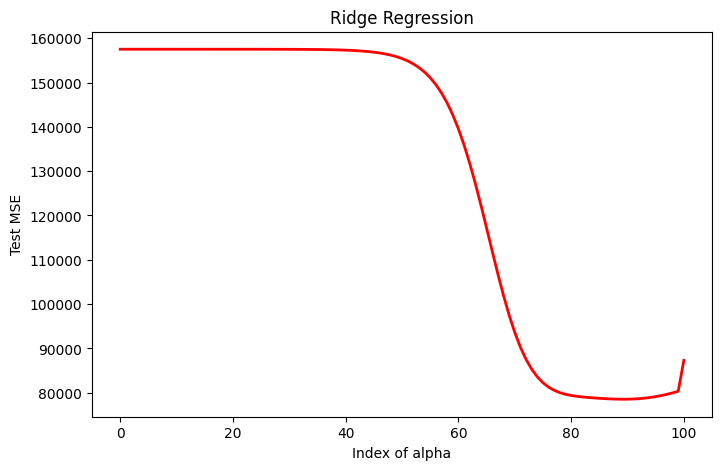

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.subplot(1,1,1)
plt.plot(range(len(mse_ridge)), mse_ridge, color='red', linewidth=2)
plt.xlabel("Index of alpha")
plt.ylabel("Test MSE")
plt.title("Ridge Regression")

In [25]:
# Find a tuning parameter for Lasso
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

alphas_lasso = np.append(np.logspace(3, 0, 50), 0)
mse_lasso = []

for l in alphas_lasso:
    lasso = Lasso(alpha=l, max_iter=10000)
    lasso.fit(train_X, train_y)
    y_pred_cv = lasso.predict(test_X)
    mse_lasso.append(mean_squared_error(test_y.to_numpy(), y_pred_cv))

min_index_lasso = np.argmin(mse_lasso)
best_alpha_lasso = alphas_lasso[min_index_lasso]
best_coef_lasso = Lasso(alpha=best_alpha_lasso,max_iter=10000).fit(train_X,train_y).coef_

In [26]:
# MSE가 가장 작은 alpha
best_alpha_lasso

6.250551925273976

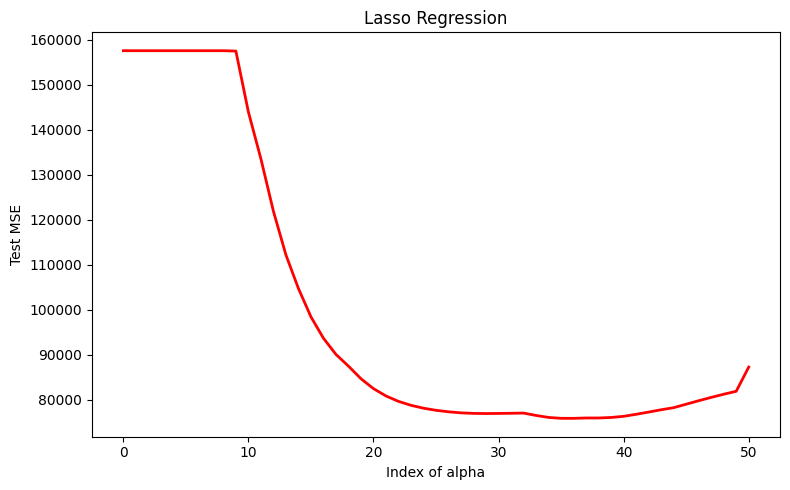

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.subplot(1,1,1)
plt.plot(range(len(mse_lasso)), mse_lasso, color='red', linewidth=2)
plt.xlabel("Index of alpha")
plt.ylabel("Test MSE")
plt.title("Lasso Regression")
plt.tight_layout()
plt.show()

### Tree-Based Method

In [28]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [29]:
# Boston housing 데이터셋 원본
url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(url, sep="\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
X = pd.DataFrame(data, columns=columns)
y = pd.Series(target, name="MEDV")

In [30]:
# Train/test split
np.random.seed(20)
train_idx = np.random.choice(X.index, size=int(len(X)/2), replace=False)
test_idx = list(set(X.index) - set(train_idx))
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [31]:
# 전체 트리 생성
tree_full = DecisionTreeRegressor(
    criterion="squared_error", 
    splitter="best",
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=20
)
tree_full.fit(X_train, y_train)

# Cost-complexity pruning path
path = tree_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# 교차 검증을 통한 alpha 선택
mse_scores = []
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(
        criterion="squared_error", 
        splitter="best",
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=20,
        ccp_alpha=alpha
    )
    scores = cross_val_score(model,X_train,y_train,
                             scoring='neg_mean_squared_error',cv=5)
    mse_scores.append(-np.mean(scores))

# 최적 alpha 선택
best_alpha = ccp_alphas[np.argmin(mse_scores)]

In [32]:
# Pruned Tree 학습
pruned_tree = DecisionTreeRegressor(
    criterion="squared_error", 
    splitter="best",
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=20,
    ccp_alpha=best_alpha
)
pruned_tree.fit(X_train, y_train)

# 테스트셋 예측 및 MSE 계산
yhat = pruned_tree.predict(X_test)
test_mse = mean_squared_error(y_test, yhat)
print("Test MSE:", test_mse)

Test MSE: 14.787540365036778


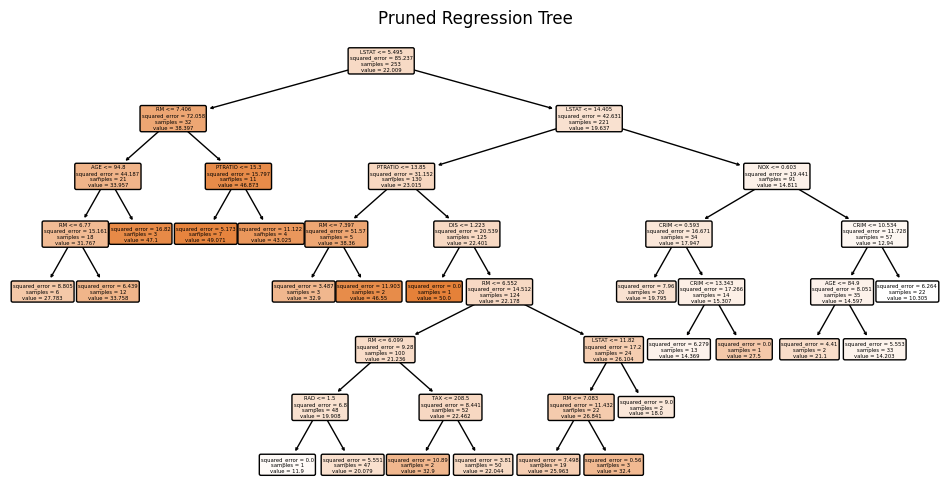

(14.787540365036778, 0.24807360535553083, 7, 21)

In [33]:
# 트리 시각화
plt.figure(figsize=(12, 6))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title("Pruned Regression Tree")
plt.show()

(test_mse, best_alpha, pruned_tree.get_depth(), pruned_tree.get_n_leaves())

In [34]:
## Bagging Model
bagging_model = RandomForestRegressor(n_estimators=100, max_features=X_train.shape[1],
                                      min_samples_split=2, min_samples_leaf=1,
                                      random_state=20, oob_score=True)
bagging_model.fit(X_train, y_train)

RandomForestRegressor(max_features=13, oob_score=True, random_state=20)

In [35]:
# 예측 오차 계산
yhat_bag = bagging_model.predict(X_test)
bagging_mse = mean_squared_error(y_test, yhat_bag)
print("Bagging Test MSE:", bagging_mse)

Bagging Test MSE: 8.995037434782605


In [36]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_features=4, random_state=42)
rf.fit(X_train, y_train)    
y_pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)

In [37]:
# 변수 중요도 계산
rf_importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

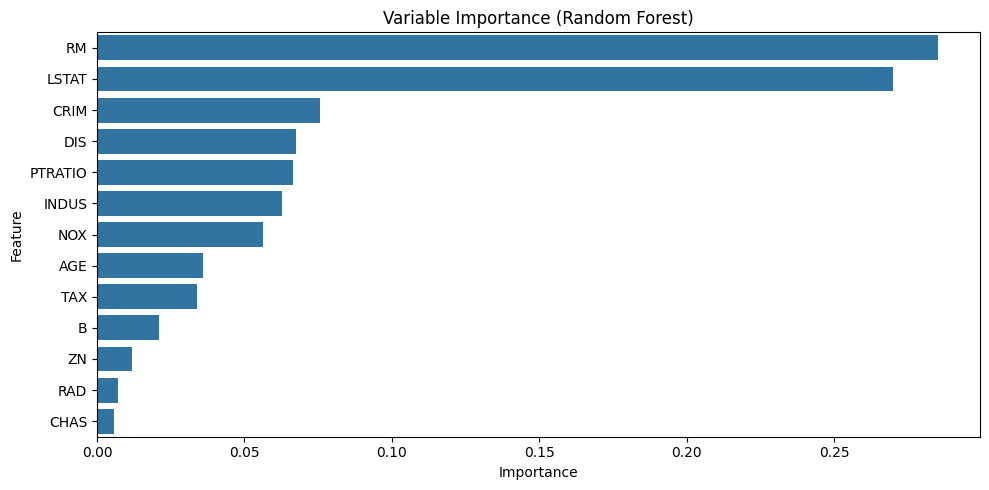

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Variable Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [39]:
# Boosting: gradient boosting machine
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay

gbm = GradientBoostingRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=2,
    random_state=123
)
gbm.fit(X_train, y_train)

# 예측오차 계산
y_pred_gbm = gbm.predict(X_test)
test_mse_gbm = mean_squared_error(y_test, y_pred_gbm)

print("Boosting Test MSE:", test_mse_gbm)

Boosting Test MSE: 10.856857844995265


In [40]:
# 변수 중요도 계산
feature_importance = pd.Series(gbm.feature_importances_,
                               index=X_train.columns).sort_values(ascending=False)

feature_importance

LSTAT      0.505776
RM         0.272146
DIS        0.063563
PTRATIO    0.040117
CRIM       0.035625
NOX        0.030239
TAX        0.016482
B          0.015198
AGE        0.011103
RAD        0.004892
CHAS       0.003022
INDUS      0.001554
ZN         0.000283
dtype: float64

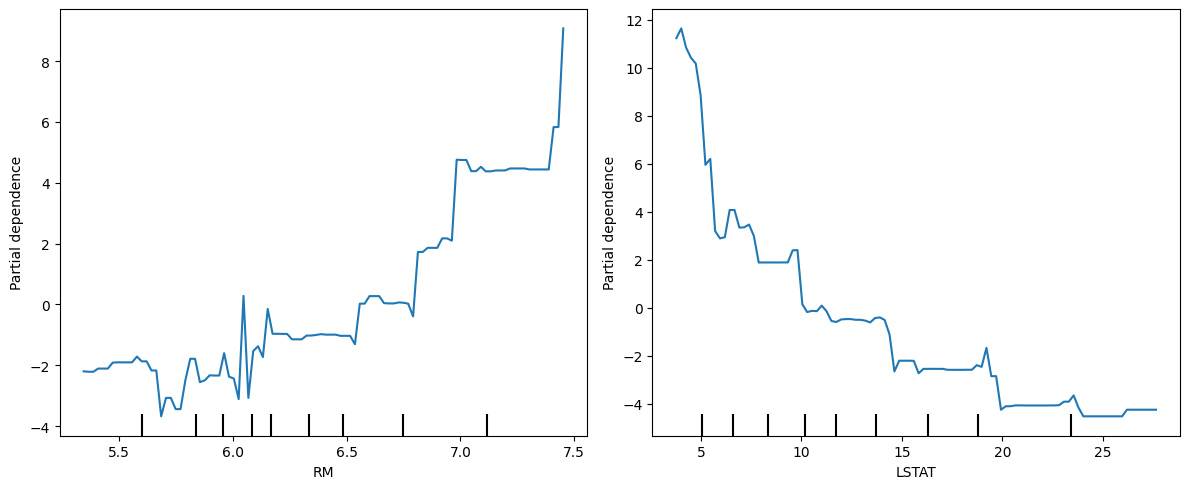

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
PartialDependenceDisplay.from_estimator(gbm, X_train, ['RM'], ax=ax[0])
PartialDependenceDisplay.from_estimator(gbm, X_train, ['LSTAT'], ax=ax[1])
plt.tight_layout()
plt.show()

In [42]:
# XGBoost with importance
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10000,
                             max_depth=2,learning_rate=0.01,verbosity=0,n_jobs=1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [43]:
# 예측 오차 계산
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost Test MSE:", xgb_mse)

XGBoost Test MSE: 9.728430290163233


    Feature  Importance
12    LSTAT    0.305926
3      CHAS    0.167189
10  PTRATIO    0.151478
5        RM    0.122047
4       NOX    0.070186
9       TAX    0.054149
7       DIS    0.043083
0      CRIM    0.026998
8       RAD    0.022487
11        B    0.012008
1        ZN    0.009106
6       AGE    0.007711
2     INDUS    0.007632


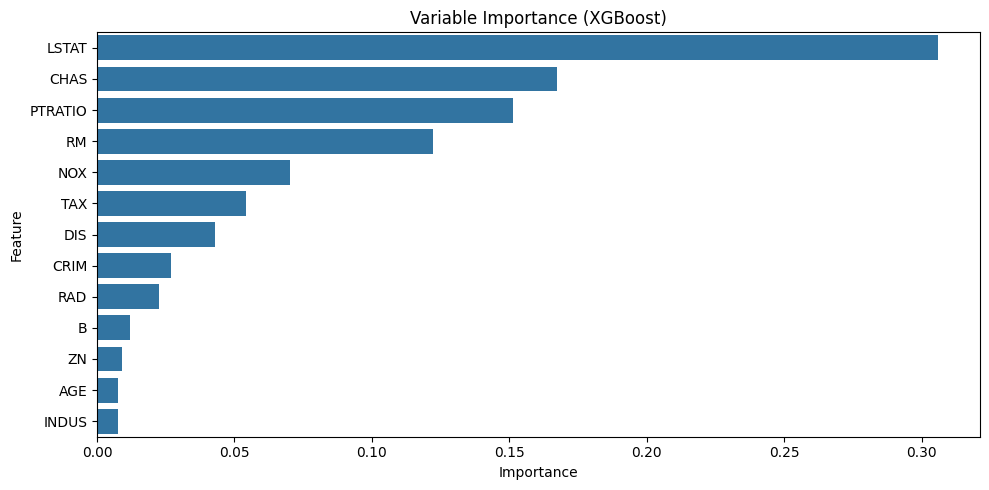

In [44]:
# 변수 중요도 
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_importance
}).sort_values(by="Importance", ascending=False)

print(xgb_importance_df)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=xgb_importance_df)
plt.title("Variable Importance (XGBoost)")
plt.tight_layout()
plt.show()

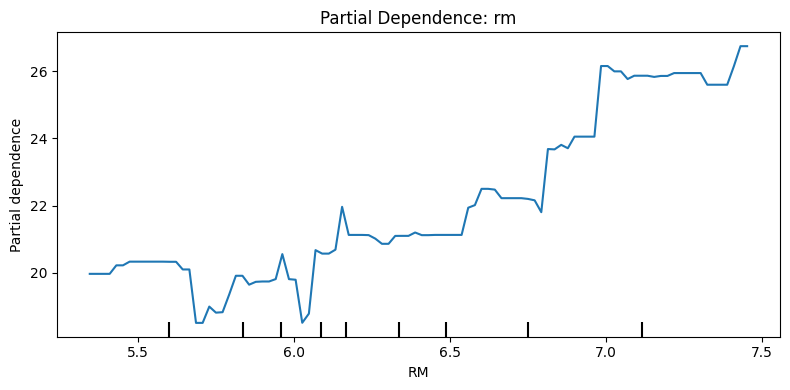

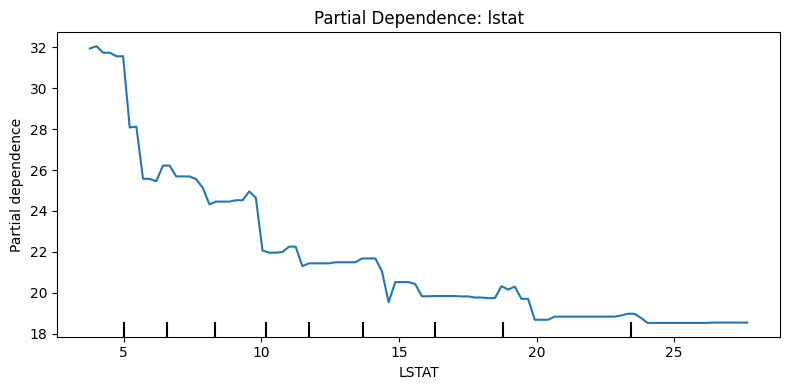

In [45]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(xgb_model, X_train, ['RM'], ax=ax)
plt.title("Partial Dependence: rm")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(xgb_model, X_train, ['LSTAT'], ax=ax)
plt.title("Partial Dependence: lstat")
plt.tight_layout()
plt.show()

### Neural Network

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [47]:
# Load Boston housing data manually
url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
X = pd.DataFrame(data, columns=columns)
y = pd.Series(target, name="MEDV")

In [48]:
# train과 test로 데이터셋 나누기
np.random.seed(20)
train_idx = np.random.choice(X.index, size=int(len(X)/2), replace=False)
test_idx = list(set(X.index) - set(train_idx))
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

In [49]:
# 정규화 (Scaler를 활용하여 정규화할 수 있지만, 여기서는 자체 제작 함수 활용)
def normalize(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

def denormalize(df_norm, min_vals, max_vals):
    return df_norm * (max_vals - min_vals) + min_vals

X_min = X_train.min()
X_max = X_train.max()
y_min = y_train.min()
y_max = y_train.max()

X_train_norm = normalize(X_train, X_min, X_max)
X_test_norm = normalize(X_test, X_min, X_max)
y_train_norm = (y_train - y_min) / (y_max - y_min)

In [50]:
### Single Hidden Layer
mlp_single = MLPRegressor(hidden_layer_sizes=(10,), activation='logistic', 
                          solver='lbfgs',alpha=0.1,max_iter=1000,random_state=30)
mlp_single.fit(X_train_norm, y_train_norm)
yhat_single_scaled = mlp_single.predict(X_test_norm)
yhat_single = denormalize(yhat_single_scaled, y_min, y_max)

# 예측오차 계산
mse_single = mean_squared_error(y_test.to_numpy(), yhat_single)

In [51]:
mlp_single.coefs_

[array([[ 4.89263648e-02, -1.02012659e-01, -1.08668055e-01,
         -4.47180286e-02, -3.11889706e-01,  1.73235930e-01,
          1.31007771e-01,  1.69826927e-01, -1.45885669e-02,
         -2.14739573e-01],
        [-3.28825199e-05,  4.95338741e-02,  3.98625869e-02,
          2.27613134e-02,  1.39602533e-01, -5.83398451e-02,
         -5.41176215e-02, -1.01249095e-01,  8.49234175e-03,
          6.45199488e-02],
        [-1.60481229e-02, -7.61276196e-03,  3.14228427e-03,
          1.80326320e-02, -5.51311026e-02,  1.71103889e-03,
          2.61806981e-03,  1.90055286e-02,  2.20455418e-02,
         -1.47586057e-02],
        [-2.58273428e-02,  4.70095995e-02,  4.03331177e-02,
          2.34947886e-02,  1.63419398e-01, -8.16609633e-02,
         -5.26260601e-02, -8.70027806e-02,  4.61313500e-03,
          8.92524802e-02],
        [ 2.53864025e-02, -4.56306625e-02, -2.89523290e-02,
         -2.03996728e-02, -1.13654732e-01,  6.47375306e-02,
          5.01515216e-02,  5.00481912e-02,  9.345935

In [52]:
mse_single

23.561376910248033

In [53]:
### Two Hidden Layers
mlp_multi = MLPRegressor(hidden_layer_sizes=(5,3), activation='logistic',
                         solver='lbfgs', max_iter=1000, random_state=30)
mlp_multi.fit(X_train_norm, y_train_norm)
yhat_multi_scaled = mlp_multi.predict(X_test_norm)
yhat_multi = denormalize(yhat_multi_scaled, y_min, y_max)

# 예측오차 계산
mse_multi = mean_squared_error(y_test, yhat_multi)

In [54]:
mlp_multi.coefs_

[array([[ 0.94130525, -1.28885434, -0.17467288,  3.55036845,  1.43667747],
        [ 0.03200634, -0.53036331,  0.35526485, -1.11404975, -0.23854254],
        [-0.74792988, -0.18614547, -0.26175199, -1.33835845, -0.1292591 ],
        [ 0.82783487, -0.43338563, -0.23777869, -0.40660805, -1.10406903],
        [ 0.26450155, -0.73497423, -0.12557723,  0.41572102, -0.11226869],
        [-0.90205698,  2.32688864,  1.66419242,  1.23677157, -3.09834064],
        [-0.17288246, -1.74583229, -0.56593538, -1.38349579, -1.02814728],
        [ 1.6353796 ,  0.54397376, -0.48486107,  4.6077636 ,  2.35037318],
        [-0.33073479, -0.62217682, -0.61961553, -2.06363796, -1.6006696 ],
        [ 0.68203857, -1.51653781, -0.70506412, -1.36195755,  0.0980552 ],
        [-0.01885945,  0.18828359, -0.88908765,  1.50003486,  1.01176649],
        [ 0.35972806,  0.82858621, -0.33148194,  0.79732998, -0.60574031],
        [ 1.81378484,  2.73354076, -1.62662101,  5.79924868,  2.99919629]]),
 array([[ 0.58652117,  

In [55]:
mse_multi

11.146196022705032

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Neural Net 시각화 함수: Python에서는 자체 시각화 함수가 없어서 제작하여 사용
# 선이 굵을수록 연결이 강함
def plot_mlp_structure(model, feature_names=None):
    coefs = model.coefs_
    intercepts = model.intercepts_
    layer_sizes = [coefs[0].shape[0]] + [w.shape[1] for w in coefs]
    n_layers = len(layer_sizes)

    # 노드 위치 계산
    v_spacing = 1.0
    h_spacing = 1.0
    node_positions = {}
    for i, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2.0
        for j in range(layer_size):
            node_positions[(i, j)] = (h_spacing * i, layer_top - v_spacing * j)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')

    for (i, j), (x, y) in node_positions.items():
        circle = plt.Circle((x, y), 0.1, fill=True, color='lightblue', ec='k')
        ax.add_patch(circle)
        if i == 0 and feature_names:
            ax.text(x - 0.3, y, feature_names[j], ha='right', va='center', fontsize=8)

    for i in range(n_layers - 1):
        for j in range(layer_sizes[i]):
            for k in range(layer_sizes[i + 1]):
                x1, y1 = node_positions[(i, j)]
                x2, y2 = node_positions[(i + 1, k)]
                weight = coefs[i][j][k]
                color = 'red' if weight < 0 else 'green'
                linewidth = np.abs(weight) * 2  # 가중치 크기에 비례
                ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth)

    plt.title("Neural Net")
    plt.show()


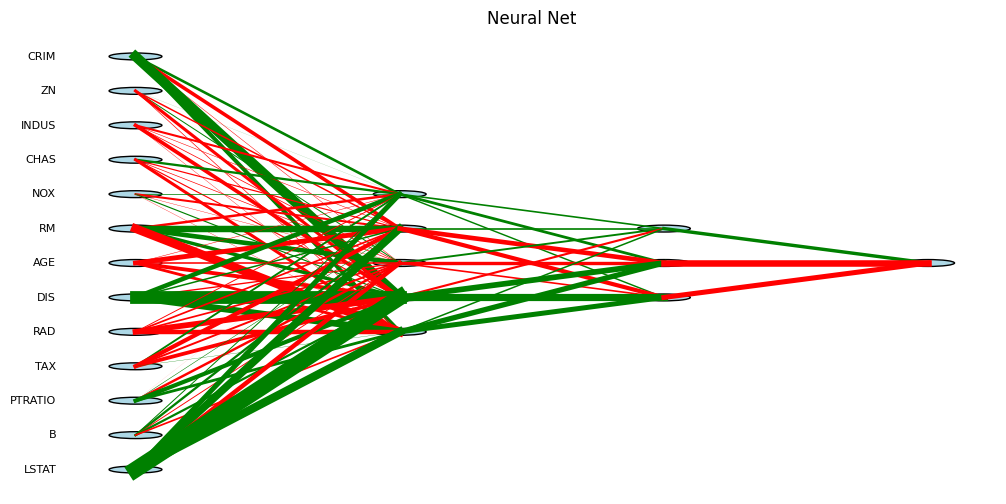

In [57]:
# Neural Net 시각화
feature_names = X_train.columns.tolist()
plot_mlp_structure(mlp_multi, feature_names)

In [58]:
### Three Hidden Layers
mlp_multi3 = MLPRegressor(hidden_layer_sizes=(7,5,3), activation='logistic',
                          solver='lbfgs', max_iter=1000, random_state=20)
mlp_multi3.fit(X_train_norm, y_train_norm)
yhat_multi3_scaled = mlp_multi3.predict(X_test_norm)
yhat_multi3 = denormalize(yhat_multi3_scaled, y_min, y_max)

# 예측오차 계산
mse_multi3 = mean_squared_error(y_test, yhat_multi3)

In [59]:
mlp_multi3.coefs_

[array([[-0.23231143,  0.10946723,  0.22870373,  0.82572166, -2.16886701,
         -0.21777333, -0.23104821],
        [ 1.21531524, -0.02573326, -0.66619129, -0.07891106, -0.40139756,
          0.66138297, -0.24347438],
        [-1.08295277, -0.68896657, -0.70779248,  0.2278063 ,  0.44462984,
         -0.60481939, -0.35062232],
        [ 1.24798575,  0.46675917,  0.53848057,  0.47249323,  0.79301172,
          0.01518166,  0.41623725],
        [-0.97673688, -0.14397757,  0.21127979, -0.25375522, -1.02140041,
         -0.83312278,  0.05018121],
        [ 1.1074767 ,  0.13225914,  0.25451119, -3.67680224, -0.64910923,
          2.23740471,  0.42668443],
        [-0.83120297, -0.38859317, -0.4600336 ,  0.60818544, -0.05388706,
         -1.0672642 , -0.3513532 ],
        [ 0.73167003,  0.06483191,  0.20141004,  0.95034791, -3.15621823,
         -0.31802044,  0.2897282 ],
        [-1.07780889, -0.35414632,  0.0102562 ,  0.47193441,  0.95424052,
         -0.92206475,  0.02360248],
        [-

In [60]:
mse_multi3

13.529917889719785

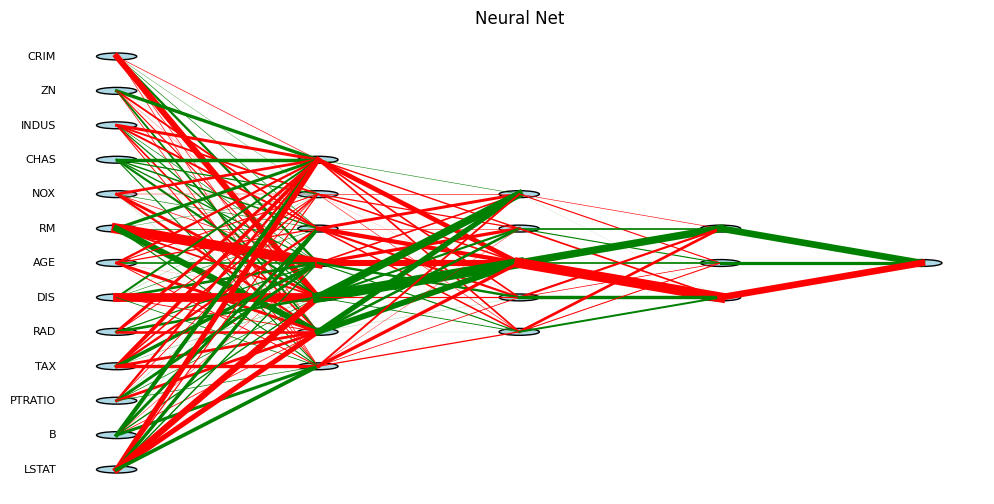

In [61]:
# Neural Net 시각화
feature_names = X_train.columns.tolist()
plot_mlp_structure(mlp_multi3, feature_names)

### LSTM

In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import random

scaler = MinMaxScaler()

In [64]:
### 데이터 불러오기
FREDMD = pd.read_excel("C:/Users/A/OneDrive/바탕 화면/RA/Machine Learning/Python Code/r_practice/FREDMDdata.xlsx", sheet_name=0)

In [65]:
### 정규화 함수

scaler = MinMaxScaler()

def normalize(df):
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def denormalize(val, minval, maxval):
    return val * (maxval - minval) + minval

In [66]:
### 데이터 정규화

FREDMX_norm = normalize(FREDMD)

In [67]:
y = FREDMX_norm['INDPRO']
X = FREDMX_norm.drop(columns=['INDPRO'])

In [68]:
n_features = len(X.T)
timestep = 4
horizon = 1

In [69]:
### 3D-Array 생성

def create_dataset(x, y, timestep, horizon):
    x = np.asarray(x)
    y = np.asarray(y)

    n_samples = x.shape[0] - timestep - horizon + 1
    X = np.empty((n_samples, timestep, x.shape[1]))
    Y = y[timestep + horizon - 1:]

    for i in range(n_samples):
        X[i] = x[i:(i + timestep), :]

    return X, Y

def create_X_out(x, timestep):
    x = np.asarray(x)
    X_last = x[-timestep:] 
    X_last = X_last.reshape((1, timestep, x.shape[1]))
    return X_last

In [70]:
ds = create_dataset(X, y, timestep, horizon)

In [71]:
X_train, y_train = create_dataset(X, y, timestep=4, horizon=1)

In [72]:
X_out_arr = create_X_out(X, timestep)

In [73]:
### Random seed 설정

random.seed(21)
np.random.seed(21)
tf.random.set_seed(21)

In [74]:
### 단일층 LSTM

model = Sequential()
model.add(LSTM(units=32, input_shape=(timestep, n_features), stateful=False))
model.add(Dense(units=1))

In [75]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                19712     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19,745
Trainable params: 19,745
Non-trainable params: 0
_________________________________________________________________


In [76]:
### 모델 학습

model.fit(X_train, y_train, epochs=100, batch_size=50,shuffle=False,verbose=2)

Epoch 1/100
10/10 - 4s - loss: 0.1141 - 4s/epoch - 359ms/step
Epoch 2/100
10/10 - 0s - loss: 0.0217 - 41ms/epoch - 4ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0171 - 37ms/epoch - 4ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0124 - 38ms/epoch - 4ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0122 - 36ms/epoch - 4ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0111 - 38ms/epoch - 4ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0111 - 38ms/epoch - 4ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0108 - 37ms/epoch - 4ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0106 - 38ms/epoch - 4ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0105 - 37ms/epoch - 4ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0104 - 35ms/epoch - 4ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0103 - 38ms/epoch - 4ms/step
Epoch 13/100
10/10 - 0s - loss: 0.0102 - 39ms/epoch - 4ms/step
Epoch 14/100
10/10 - 0s - loss: 0.0102 - 40ms/epoch - 4ms/step
Epoch 15/100
10/10 - 0s - loss: 0.0101 - 39ms/epoch - 4ms/step
Epoch 16/100
10/10 - 0s - loss: 0.0100 - 40ms/epoch - 4ms/step
E

In [77]:
### 예측

h_step_ahead_pred = model.predict(X_out_arr)

1/1 [==============================] - 1s 704ms/step


In [78]:
x_min = FREDMD.apply(min)
x_max = FREDMD.apply(max)

y_min = x_min['INDPRO']
y_max = x_max['INDPRO']

In [79]:
### Denormalize하여 예측값 생성

y_pred = denormalize(h_step_ahead_pred, y_min, y_max)

In [80]:
y_pred

array([[-0.00100458]], dtype=float32)

In [81]:
### 2-layer LSTM with dropout (rate = 0.3)

model2 = Sequential()
model2.add(LSTM(units=32, input_shape=(timestep, n_features), return_sequences=True, stateful=False))
model2.add(Dropout(rate=0.3))
model2.add(LSTM(units=16))
model2.add(Dropout(rate=0.3))
model2.add(Dense(units=1))

In [82]:
model2.compile(loss='mse', optimizer='adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4, 32)             19712     
                                                                 
 dropout (Dropout)           (None, 4, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 22,865
Trainable params: 22,865
Non-trainable params: 0
_________________________________________________________________


In [83]:
### 모델 학습

model2.fit(X_train, y_train, epochs=100, batch_size=50, shuffle=False, verbose=2)

Epoch 1/100
10/10 - 6s - loss: 0.1428 - 6s/epoch - 620ms/step
Epoch 2/100
10/10 - 0s - loss: 0.0498 - 65ms/epoch - 7ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0385 - 66ms/epoch - 7ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0294 - 67ms/epoch - 7ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0278 - 67ms/epoch - 7ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0254 - 67ms/epoch - 7ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0261 - 66ms/epoch - 7ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0273 - 65ms/epoch - 7ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0288 - 63ms/epoch - 6ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0253 - 65ms/epoch - 7ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0247 - 81ms/epoch - 8ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0232 - 64ms/epoch - 6ms/step
Epoch 13/100
10/10 - 0s - loss: 0.0208 - 68ms/epoch - 7ms/step
Epoch 14/100
10/10 - 0s - loss: 0.0229 - 69ms/epoch - 7ms/step
Epoch 15/100
10/10 - 0s - loss: 0.0233 - 65ms/epoch - 7ms/step
Epoch 16/100
10/10 - 0s - loss: 0.0220 - 72ms/epoch - 7ms/step
E

In [84]:
### 예측

h_step_ahead_pred2 = model2.predict(X_out_arr)

1/1 [==============================] - 1s 1s/step


In [85]:
### Denormalize하여 예측값 생성

y_pred2 = denormalize(h_step_ahead_pred2, y_min, y_max)

In [86]:
h_step_ahead_pred2

array([[0.53835905]], dtype=float32)